# U²-Net: Deep Learning for Image-to-Sketch Conversion

## Project Overview

This notebook demonstrates the implementation of **U²-Net (U-square Net)**, a powerful deep learning architecture designed for salient object detection and image segmentation tasks. We'll use it specifically for converting photographic portraits into artistic sketches.

### What is U²-Net?

U²-Net is a two-level nested U-structure architecture that combines:
- **Deep network architecture** for capturing multi-scale features
- **Efficient design** that balances performance and computational cost
- **High-quality results** for image segmentation and salient object detection

### Key Applications
- Portrait sketch generation
- Background removal
- Salient object detection
- Image matting
- Edge detection

## Architecture Overview

### U²-Net Architecture

```
                    INPUT IMAGE (3 channels)
                           |
                           v
        ┌──────────────────────────────────────┐
        │         ENCODER (Downsampling)       │
        │  ┌────────────────────────────────┐  │
        │  │  Stage 1: RSU-7 (64 channels)  │  │  ──┐
        │  └────────────┬───────────────────┘  │    │
        │               │ MaxPool              │    │
        │  ┌────────────v───────────────────┐  │    │
        │  │  Stage 2: RSU-6 (128 channels) │  │  ──┤
        │  └────────────┬───────────────────┘  │    │
        │               │ MaxPool              │    │
        │  ┌────────────v───────────────────┐  │    │
        │  │  Stage 3: RSU-5 (256 channels) │  │  ──┤ Skip
        │  └────────────┬───────────────────┘  │    │ Connections
        │               │ MaxPool              │    │
        │  ┌────────────v───────────────────┐  │    │
        │  │  Stage 4: RSU-4 (512 channels) │  │  ──┤
        │  └────────────┬───────────────────┘  │    │
        │               │ MaxPool              │    │
        │  ┌────────────v───────────────────┐  │    │
        │  │  Stage 5: RSU-4F (512 channels)│  │  ──┤
        │  └────────────┬───────────────────┘  │    │
        │               │ MaxPool              │    │
        │  ┌────────────v───────────────────┐  │    │
        │  │  Stage 6: RSU-4F (512 channels)│  │  ──┘
        │  └────────────┬───────────────────┘  │
        └───────────────┼───────────────────────┘
                        │ Bottleneck
        ┌───────────────┼───────────────────────┐
        │         DECODER (Upsampling)         │
        │  ┌────────────v───────────────────┐  │
        │  │  Stage 5d: RSU-4F + Skip       │  │
        │  └────────────┬───────────────────┘  │
        │               │ Upsample             │
        │  ┌────────────v───────────────────┐  │
        │  │  Stage 4d: RSU-4 + Skip        │  │
        │  └────────────┬───────────────────┘  │
        │               │ Upsample             │
        │  ┌────────────v───────────────────┐  │
        │  │  Stage 3d: RSU-5 + Skip        │  │
        │  └────────────┬───────────────────┘  │
        │               │ Upsample             │
        │  ┌────────────v───────────────────┐  │
        │  │  Stage 2d: RSU-6 + Skip        │  │
        │  └────────────┬───────────────────┘  │
        │               │ Upsample             │
        │  ┌────────────v───────────────────┐  │
        │  │  Stage 1d: RSU-7 + Skip        │  │
        │  └────────────┬───────────────────┘  │
        └───────────────┼───────────────────────┘
                        │
        ┌───────────────v───────────────────────┐
        │    SIDE OUTPUTS & FUSION LAYER        │
        │  (Concatenate all decoder outputs)    │
        └───────────────┬───────────────────────┘
                        │
                        v
              OUTPUT (1 channel - sketch)
```

### RSU Block (Residual U-block)

The core building block of U²-Net is the RSU (Residual U-block):

```
    Input
      │
      ├──────────────────────────────────┐
      │                                  │ (Skip)
      v                                  │
  ┌───────┐                              │
  │ Conv  │ ← Initial Convolution        │
  └───┬───┘                              │
      │                                  │
      v                                  │
  ┌───────────────────────┐              │
  │  U-shaped Structure   │              │
  │  (Encoder-Decoder)    │              │
  │  - Multiple scales    │              │
  │  - Residual connections│             │
  └───────────┬───────────┘              │
              │                          │
              v                          │
            ┌───┐                        │
            │ + │ ← Residual Addition  ←─┘
            └─┬─┘
              │
              v
           Output
```

## Installation & Setup

First, let's import all necessary libraries and configure the environment.

In [16]:
# Suppress warnings for cleaner output
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
from PIL import Image
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image processing
from skimage import io, transform

# PyTorch Deep Learning Framework
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

# Set plotting style
sns.set_context('notebook')
sns.set_style('white')

print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch Version: 2.10.0+cu128
Device: GPU


## Utility Functions

### 1. Forward Pass Helper for RSU Blocks

This function orchestrates the forward pass through an RSU block by:
1. Separating encoder and decoder layers
2. Processing through encoder with skip connections
3. Processing through decoder with upsampling
4. Adding residual connection

In [17]:
def f(modules_dict, x):
    """
    Forward pass function for RSU blocks.
    
    This function implements the U-shaped structure within each RSU block:
    - Encoder path: Downsampling with max pooling
    - Decoder path: Upsampling with skip connections
    - Residual connection: Element-wise addition with input
    
    Args:
        modules_dict: OrderedDict containing all modules of the RSU block
        x: Input tensor
    
    Returns:
        Output tensor with residual connection
    """
    # Separate encoder and decoder layers based on naming convention
    inner_enc_layers = []
    inner_dec_layers = []
    
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':  # Decoder layers end with 'd'
            inner_dec_layers.append(layer)
        else:  # Encoder layers
            inner_enc_layers.append(layer)

    # Initial input processing
    hx = x
    hxin = inner_enc_layers[0](hx)  # Store for residual connection
    hx = hxin
    inner_enc_outputs = []

    # ENCODER PATH: Progressive downsampling
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        # Store encoder outputs for skip connections (exclude pooling layers)
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)

    # DECODER PATH: Progressive upsampling with skip connections
    # Start by concatenating the two deepest encoder outputs
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()), 1))
    
    # Continue upsampling and merging with encoder features
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_like(hxd, inner_enc_outputs[-1])  # Match spatial dimensions
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()), 1))  # Concatenate skip connection

    # RESIDUAL CONNECTION: Add input to output
    return hxd + hxin

### 2. Prediction Normalization

Normalizes model predictions to [0, 1] range for visualization and post-processing.

In [18]:
def normPRED(d):
    """
    Normalize prediction to [0, 1] range.
    
    This is crucial for:
    - Converting model outputs to valid image intensities
    - Ensuring consistent visualization
    - Preparing outputs for post-processing
    
    Args:
        d: Input tensor (model prediction)
    
    Returns:
        Normalized tensor in range [0, 1]
    """
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn

### 3. Upsampling Function

Resizes feature maps to match target dimensions using bilinear interpolation.

In [19]:
def _upsample_like(src, tar):
    """
    Upsample source tensor to match target tensor's spatial dimensions.
    
    Uses bilinear interpolation for smooth upsampling.
    Essential for:
    - Matching encoder and decoder feature map sizes
    - Enabling skip connections at different scales
    - Producing final output at original resolution
    
    Args:
        src: Source tensor to upsample
        tar: Target tensor (provides target dimensions)
    
    Returns:
        Upsampled source tensor
    """
    src = F.interpolate(src, size=tar.shape[2:], mode='bilinear', align_corners=False)
    return src

## Data Preprocessing

### Custom Transform Classes

These classes prepare input images for the neural network:
1. **RescaleT**: Resizes images to 512×512 (model's expected input size)
2. **ToTensor**: Converts to tensor and normalizes using ImageNet statistics

In [20]:
class RescaleT(object):
    """
    Rescale image to a given size.
    
    U²-Net expects 512×512 input images for optimal performance.
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        img = transform.resize(image, (self.output_size, self.output_size), mode='constant')
        return {'imidx': imidx, 'image': img}


class ToTensor(object):
    """
    Convert ndarrays to Tensors with normalization.
    
    Applies ImageNet normalization:
    - Mean: [0.485, 0.456, 0.406]
    - Std: [0.229, 0.224, 0.225]
    
    This matches the statistics of the dataset used for pre-training.
    """
    def __init__(self, flag=0):
        self.flag = flag

    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        
        # Normalize to [0, 1]
        image = image / np.max(image)

        # Apply channel-wise normalization (ImageNet statistics)
        tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229  # Red
        tmpImg[:, :, 1] = (image[:, :, 1] - 0.456) / 0.224  # Green
        tmpImg[:, :, 2] = (image[:, :, 2] - 0.406) / 0.225  # Blue

        # Convert to PyTorch format: (C, H, W)
        tmpImg = tmpImg.transpose((2, 0, 1))

        return {'imidx': torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg)}

## Neural Network Architecture

### 1. REBNCONV Block

The fundamental building block: **Conv → BatchNorm → ReLU**

```
Input → [Conv2d] → [BatchNorm2d] → [ReLU] → Output
```

In [21]:
class REBNCONV(nn.Module):
    """
    Residual Encoder Block Convolution.
    
    Basic building block combining:
    - Convolution: Extract features
    - Batch Normalization: Stabilize training
    - ReLU: Non-linear activation
    
    Args:
        in_ch: Number of input channels
        out_ch: Number of output channels
        dirate: Dilation rate for dilated convolution
    """
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()
        
        self.conv_s1 = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu_s1(self.bn_s1(self.conv_s1(x)))

### 2. RSU-7 Block (Residual U-block with 7 layers)

A U-shaped structure with 7 convolutional layers, featuring:
- 6 encoder stages with progressive downsampling
- 6 decoder stages with progressive upsampling
- Skip connections between corresponding encoder-decoder pairs
- Final residual connection

In [22]:
class RSU7(nn.Module):
    """
    Residual U-block with 7 convolutional layers.
    
    Structure:
    - 6 encoder layers (with 5 max-pooling operations)
    - 1 bottleneck layer
    - 6 decoder layers (with upsampling and skip connections)
    
    This captures features at multiple scales while maintaining
    fine-grained details through skip connections.
    """
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        # Input convolution (stored for residual)
        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        # ENCODER
        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # BOTTLENECK
        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)  # Dilated for larger receptive field

        # DECODER (concatenates with encoder features)
        self.rebnconv6d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch, dirate=1)

    def forward(self, x):
        # Use the helper function to process through U-structure
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### 3. RSU-6 Block

Similar to RSU-7 but with 6 layers (one less encoder-decoder pair).

In [23]:
class RSU6(nn.Module):
    """Residual U-block with 6 convolutional layers."""
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch, dirate=1)

    def forward(self, x):
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### 4. RSU-5 Block

In [24]:
class RSU5(nn.Module):
    """Residual U-block with 5 convolutional layers."""
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch, dirate=1)

    def forward(self, x):
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### 5. RSU-4 Block

In [25]:
class RSU4(nn.Module):
    """Residual U-block with 4 convolutional layers."""
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch, dirate=1)

    def forward(self, x):
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

### 6. RSU-4F Block (Dilated version without pooling)

A variant of RSU-4 that uses **dilated convolutions** instead of pooling to:
- Maintain spatial resolution
- Expand receptive field
- Reduce memory usage in deeper layers

In [26]:
class RSU4F(nn.Module):
    """
    Residual U-block with 4 layers using dilated convolutions.
    
    'F' stands for 'Full resolution' - no pooling operations.
    Uses dilated convolutions to expand receptive field without
    reducing spatial dimensions.
    """
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)  # Dilated
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)  # More dilated
        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)  # Even more dilated

        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch, dirate=1)

    def forward(self, x):
        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)
        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), 1))

        return hx1d + hxin

### 7. Complete U²-Net Architecture

The full network combines:
- **6 encoder stages** (progressively increasing channels: 64→128→256→512→512→512)
- **6 decoder stages** (symmetric to encoder)
- **Deep supervision** with side outputs from each decoder stage
- **Multi-scale fusion** combining all decoder outputs

In [27]:
class U2NET(nn.Module):
    """
    U²-Net: A two-level nested U-structure for salient object detection.
    
    Architecture highlights:
    - 6-stage encoder-decoder with RSU blocks
    - Progressive channel expansion: 64 → 128 → 256 → 512 → 512 → 512
    - Deep supervision with side outputs
    - Multi-scale feature fusion
    
    Args:
        in_ch: Input channels (3 for RGB)
        out_ch: Output channels (1 for binary mask/sketch)
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NET, self).__init__()

        # ==================== ENCODER ====================
        self.stage1 = RSU7(in_ch, 32, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # Bottleneck
        self.stage6 = RSU4F(512, 256, 512)

        # ==================== DECODER ====================
        self.stage5d = RSU4F(1024, 256, 512)  # 512 + 512 from skip connection
        self.stage4d = RSU4(1024, 128, 256)   # 512 + 512
        self.stage3d = RSU5(512, 64, 128)     # 256 + 256
        self.stage2d = RSU6(256, 32, 64)      # 128 + 128
        self.stage1d = RSU7(128, 16, 64)      # 64 + 64

        # ==================== SIDE OUTPUTS ====================
        # Each decoder stage produces a prediction
        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)

        # ==================== FUSION LAYER ====================
        # Combines all 6 side outputs
        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):
        # ==================== ENCODER PATH ====================
        hx = x

        # Stage 1: 64 channels
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # Stage 2: 128 channels
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # Stage 3: 256 channels
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # Stage 4: 512 channels
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # Stage 5: 512 channels
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # Stage 6 (Bottleneck): 512 channels
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # ==================== DECODER PATH ====================
        # Progressively upsample and merge with encoder features
        
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # ==================== SIDE OUTPUTS ====================
        # Generate predictions at each scale
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        # ==================== FUSION ====================
        # Combine all predictions
        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        # Return final prediction with sigmoid activation
        return torch.sigmoid(d0)

## Model Initialization

Create the U²-Net model with:
- 3 input channels (RGB)
- 1 output channel (grayscale sketch/mask)

In [28]:
# Initialize the network
net = U2NET(3, 1)

# Print model summary
print("U²-Net Model Created Successfully!")
print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")

U²-Net Model Created Successfully!
Total parameters: 44,009,869
Trainable parameters: 44,009,869


## Load Pre-trained Weights

We'll load pre-trained weights trained on a large dataset of portraits.

**Note**: Download the pre-trained model weights and place them in the `pretrained_u2net` folder.

In [29]:
# For local setup, download weights manually and load:
try:
    # Create directory if it doesn't exist
    os.makedirs('pretrained_u2net', exist_ok=True)
    
    # Load the pre-trained weights
    model_path = 'pretrained_u2net/u2net.pth'
    if os.path.exists(model_path):
        net.load_state_dict(torch.load(model_path, map_location='cpu'))
        print(" Pre-trained weights loaded successfully!")
    else:
        print("⚠ Pre-trained weights not found. Please download them.")
        print("   You can train from scratch or download weights from:")
        print("   https://github.com/xuebinqin/U-2-Net")
        
except Exception as e:
    print(f"Error loading weights: {e}")

# Set model to evaluation mode
net.eval()
print("Model ready for inference!")

 Pre-trained weights loaded successfully!
Model ready for inference!


## Custom Dataset Loader

Create a PyTorch Dataset class to load and preprocess images.

In [39]:
class LoadDataset(Dataset):
    """
    Custom PyTorch Dataset for loading images.
    
    Features:
    - Loads images from a directory
    - Applies transformations (resize, normalize)
    - Compatible with PyTorch DataLoader
    """
    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir: Directory containing images
            transform: Composition of transforms to apply
        """
        self.img_dir = img_dir
        self.transform = transform
        # Filter out hidden files (starting with '.')
        # self.img_name_list = [x for x in os.listdir(img_dir) if (not x.startswith(".") and x.endswith(".jpeg", ".jpg"))]
        self.img_name_list = [x for x in os.listdir(img_dir) if not x.endswith(".md")] 
    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load image
        img_name = os.path.join(self.img_dir, self.img_name_list[idx])
        image = io.imread(img_name)
        
        # Handle grayscale images
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        
        imidx = np.array([idx])
        sample = {'imidx': imidx, 'image': image}

        # Apply transformations
        if self.transform:
            sample = self.transform(sample)

        return sample

## Prepare Test Data

Load test images and create a DataLoader.

In [40]:
# Create directories for images
os.makedirs('./images', exist_ok=True)
os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# Create dataset with transformations
test_photos_path = './images'

if os.path.exists(test_photos_path) and os.listdir(test_photos_path):
    photos_dataset = LoadDataset(
        img_dir=test_photos_path,
        transform=transforms.Compose([
            RescaleT(512),  # Resize to 512x512
            ToTensor(0)     # Convert to tensor and normalize
        ])
    )
    
    # Create DataLoader
    photos_dataloader = DataLoader(photos_dataset, batch_size=1, shuffle=False)
    print(f" Loaded {len(photos_dataset)} test images")
else:
    print("⚠ No test images found. Please add images to './images/' directory.")
    photos_dataloader = None

 Loaded 1 test images


## Visualize Input Images

Display the test images before processing.

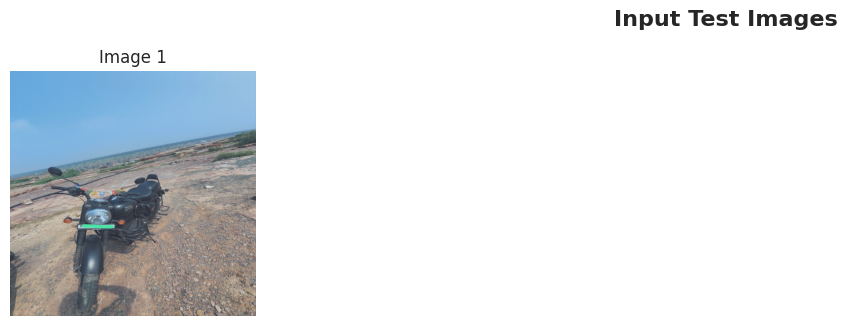

In [41]:
if photos_dataloader is not None:
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Input Test Images', fontsize=16, fontweight='bold')

    for i, sample in enumerate(photos_dataloader):
        if i >= 10:  # Limit to 10 images
            break
            
        # Denormalize image for display
        img_arr = np.transpose((sample['image'].numpy()[0] + 3) / 6, (1, 2, 0))
        img_arr = np.clip(img_arr, 0, 1)  # Ensure values are in [0, 1]
        
        ax = fig.add_subplot(2, 5, i + 1)
        ax.imshow(img_arr)
        ax.set_title(f'Image {i+1}')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No images to display")

## Inference: Generate Sketches

Process images through the network to generate artistic sketches.

### Processing Pipeline:
1. **Input**: RGB image (512×512)
2. **Forward pass**: Through U²-Net encoder-decoder
3. **Output**: Probability map (0=background, 1=foreground)
4. **Inversion**: Invert to create sketch effect (1 - output)
5. **Normalization**: Scale to [0, 255] for visualization

In [ ]:
if photos_dataloader is not None:
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle('Generated Sketches', fontsize=16, fontweight='bold')

    with torch.no_grad():  # Disable gradient computation for inference
        for i, sample in enumerate(photos_dataloader):
            if i >= 10:  # Limit to 10 images
                break
                
            print(f"Processing image #{i+1}...")

            # Prepare input
            input_test = sample['image'].type(torch.FloatTensor)
            input_test = Variable(input_test)

            # Forward pass
            d = net(input_test)

            # Post-processing
            pred = 1.0 - d[:, 0, :, :]  # Invert for sketch effect
            pred = normPRED(pred)        # Normalize to [0, 1]

            # Convert to numpy for visualization
            predict = pred.squeeze().cpu().data.numpy()
            img = Image.fromarray(predict * 255).convert('RGB')
            img_array = np.array(img)

            # Display
            ax = fig.add_subplot(2, 5, i + 1)
            ax.imshow(img_array)
            ax.set_title(f'Sketch {i+1}')
            ax.axis("off")
            
            # Save result
            img.save(f'./results/sketch_{i+1}.png')

            # Clean up memory
            del input_test, d, pred, predict, img, img_array

    plt.tight_layout()
    plt.show()
    print("\n Sketches saved to './results/' directory")
else:
    print("No images to process")

Processing image #1...


## Exercise: Process Custom Images

### Instructions:
1. Upload custom photos to the `./images/` directory
2. Run the cells below to create a dataloader for custom images
3. Generate sketches from custom photos

### Step 1: Create DataLoader for custom Photos

In [ ]:
# Create dataset for custom photos
my_photos_path = './images'

if os.path.exists(my_photos_path) and os.listdir(my_photos_path):
    custom_dataset = LoadDataset(
        img_dir=my_photos_path,
        transform=transforms.Compose([
            RescaleT(512),
            ToTensor(0)
        ])
    )
    
    custom_dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=False)
    print(f" Loaded {len(custom_dataset)} of custom images")
    print("Ready to generate sketches!")
else:
    print("⚠ No images found in './images/' directory.")
    print("   Please upload custom images and run this cell again.")
    custom_dataloader = None

### Step 2: Generate Sketches from custom Photos

In [ ]:
if custom_dataloader is not None:
    os.makedirs('./results/my_sketches', exist_ok=True)
    
    print("Generating sketches from custom photos...\n")
    
    with torch.no_grad():
        for i, sample in enumerate(custom_dataloader):
            print(f"Processing custom photo #{i+1}...")

            # Prepare input
            input_test = Variable(sample['image'].type(torch.FloatTensor))
            
            # Forward pass
            d = net(input_test)

            # Post-processing
            pred = normPRED(1.0 - d[:, 0, :, :])

            # Convert to image
            predict = pred.squeeze().cpu().data.numpy()
            img = Image.fromarray(predict * 255).convert('RGB')

            # Display
            plt.figure(figsize=(10, 10))
            plt.imshow(np.array(img))
            plt.title(f'custom Sketch #{i+1}', fontsize=14, fontweight='bold')
            plt.axis("off")
            plt.show()
            
            # Save
            img.save(f'./results/my_sketches/sketch_{i+1}.png')

            # Clean up
            del input_test, d, pred, predict, img
    
    print("\n custom sketches saved to './results/my_sketches/' directory")
else:
    print("Please upload images first!")

## Summary & Key Takeaways

### What We Learned:

1. **U²-Net Architecture**
   - Two-level nested U-structure
   - RSU blocks for multi-scale feature extraction
   - Deep supervision with side outputs

2. **Key Components**
   - **Encoder**: Progressive downsampling (6 stages)
   - **Decoder**: Progressive upsampling with skip connections
   - **RSU Blocks**: Residual U-blocks at different depths
   - **Fusion Layer**: Combines multi-scale predictions

3. **Applications**
   - Portrait to sketch conversion
   - Salient object detection
   - Background removal
   - Image segmentation

### Performance Characteristics:

- **Parameters**: ~44M parameters
- **Input**: 512×512 RGB images
- **Output**: 512×512 single-channel masks/sketches
- **Speed**: Real-time on GPU, ~1-2 seconds per image on CPU

### Further Exploration:

- Try different image types (landscapes, animals, objects)
- Experiment with post-processing (thresholding, edge enhancement)
- Fine-tune on custom datasets
- Combine with style transfer techniques

### References:

- Original Paper: [U²-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)
- GitHub: https://github.com/xuebinqin/U-2-Net

---

**Congratulations!** You've successfully implemented and used U²-Net for image-to-sketch conversion! 🎉